# Preamble

## Imports

In [1]:
from functions.colours          import *
from functions.measurement      import *
from functions.optical_modes    import *
from functions.plotting         import *
from functions.propagation      import *

from LightPipes                 import *

import aotools
import cmath

pmap, imap, customColoursBGY, customColoursViridis = colours()

# Channel Creation and Propagation

## Create Channel and Prop OAM

In [3]:
#Simulation Parameters
size = 40*cm
N = 64

lensSize=size/4 # Radius

#Beam Parameters
wavelength = 633*nm
w0=6.67/1.5*cm # Radius

#Propagataion Params
z=5000*m
numberOfPhaseScreens=3

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}

TurbStrength = 'MidWeakTurb'

r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
# Turbulence=2
# r0=size/Turbulence

phase_screen_seed=47

abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

#Default Beam
F=Begin(size,wavelength,N)

100%|██████████| 4/4 [00:00<00:00, 111.08it/s]


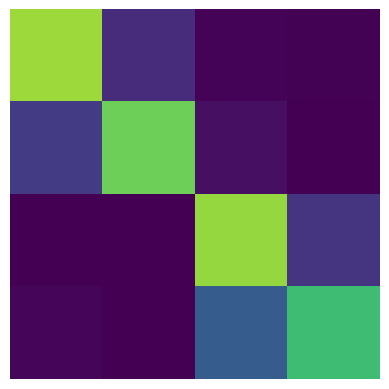

Error rate of 0.20830069369717374


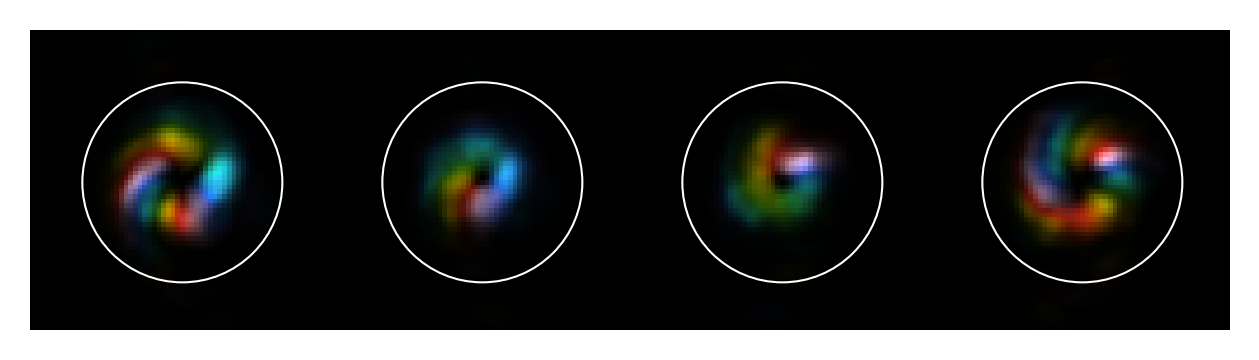

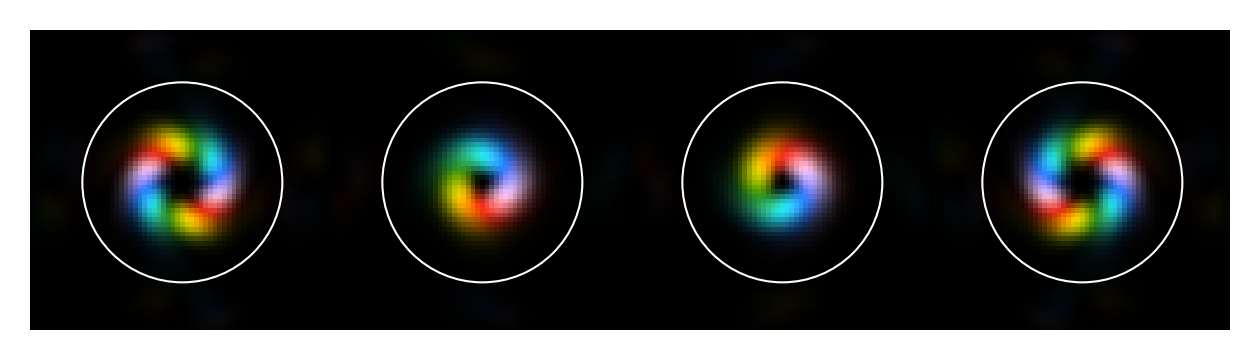

In [4]:
beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(ell(4))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs) for i in progress(ell(4))]


plt.show(plotCrosstalk(crosstalk(beams,errorBeams)))
print(f'Error rate of {beamsError(beams,errorBeams)}')

plt.show(plot_beam(errorBeams,rows=1,aperature=size/3))
plt.show(plot_beam(beams,rows=1,aperature=size/3))

## Propagate a Singel Pixel with No Turbulence

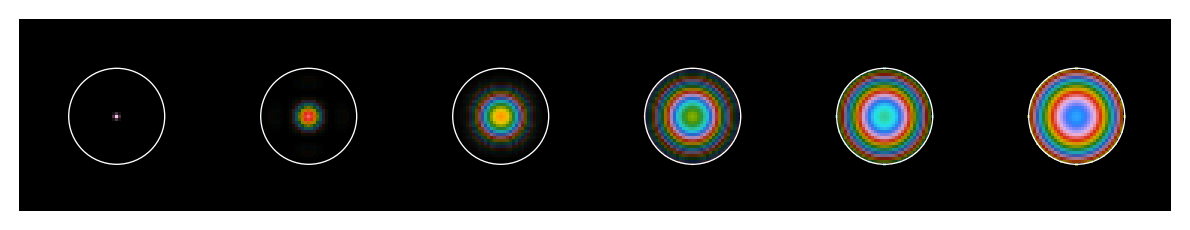

In [5]:
intens = np.zeros((N, N))
intens[N//2][N//2] = 1

#FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
#FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
F2 = [CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(F, intens),np.zeros((N,N))),R=lensSize), dist),R=lensSize) for dist in [1,1000,2000,3000,4000,5000]]

plt.show(plot_beam(F2,aperature=lensSize,dpi=3*N))


## Propagate all Pixels

In [6]:
# if __name__ == "__main__":
#     FieldsOut, endFields = parallelpropagatePixels(F, N, z, lensSize, abbs)
#     print(f"Successfully processed {len(endFields)} pixels.")

## Infinite Phase Screen

### Kolmogerov statistics

In [7]:
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
# Note that i set L0=75, if you try L0=100 you get some error at least for N=64. For N=64 we need L0<90 from my testing
# N=128 we need L0<41. Actually using L0=40 makes it look totally fucked lol. Even L0=30 is messed. Using L0=25 is nice... looks like using a small L0 with more resolution is the fix
L0 = N * size / N * 50
inf_ps = PhaseScreenKolmogorov(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed, stencil_length_factor=4)
inf_ps1 = inf_ps.scrn
inf_ps2 = PhaseScreenKolmogorov.get_new_row(inf_ps)

for i in range(0,int(N*100)):
    inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)

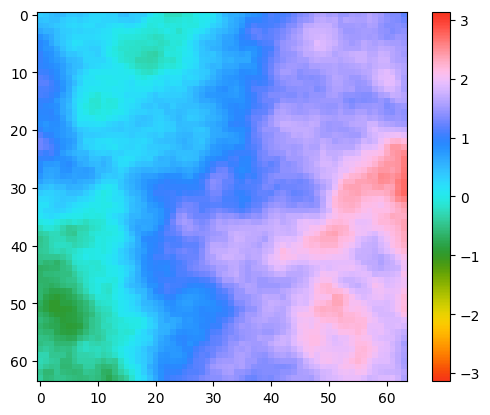

In [8]:
plt.imshow(wrap_to_pi(inf_ps1), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

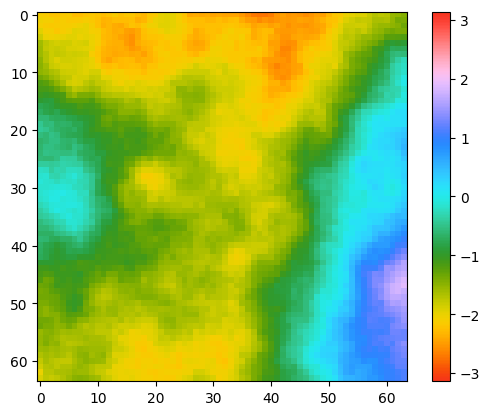

In [9]:
plt.imshow(wrap_to_pi(inf_ps3), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

### Von Karman statistics

In [10]:
# Infinite phase screens but with Von Karmon statistics

from aotools.turbulence.infinitephasescreen import PhaseScreenVonKarman
L0 = N * size / N * 50 # outer scale
inf_ps = PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0, random_seed=phase_screen_seed)
inf_ps1 = inf_ps.scrn.copy()

# for i in range(0,int(N*10)):
#     inf_ps2 = PhaseScreenVonKarman.add_row(inf_ps)

# print(inf_ps.scrn)
# print('\n\n\n')
inf_ps.scrn[:] = np.flipud(inf_ps.scrn)
# print(inf_ps.scrn)
for _ in range(0, 20):
    inf_ps4 = PhaseScreenVonKarman.add_row(inf_ps)
inf_ps4 = np.flipud(inf_ps4)

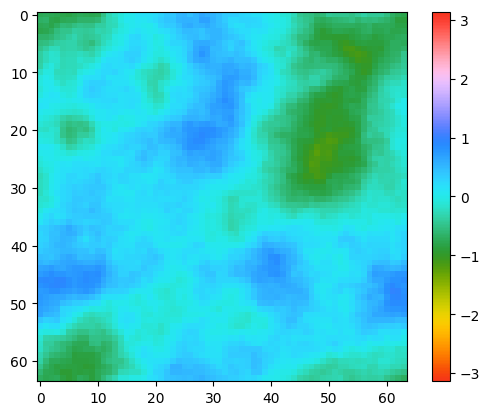

In [11]:
plt.imshow(wrap_to_pi(inf_ps1), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [12]:
# plt.imshow(wrap_to_pi(inf_ps2), cmap=pmap, vmin=-np.pi, vmax=np.pi)
# plt.colorbar()

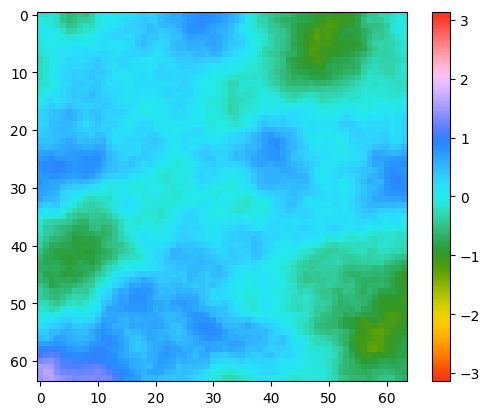

In [13]:
plt.imshow(wrap_to_pi(inf_ps4), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [14]:
# PSUEDO CODE for adding phase screens incrementally and propagating a beam through them

# beam=OAM(F,w0+w0/2,0)
# plt.show(plotBeam(beam))

# for i in range(0,int(N/1.5)):

#     inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)
    
#     plt.savefig(plotBeam(propChannel(beam,z,abbs)))

## Saving images

### Saving images of gaussian beam after propagating

In [15]:
# Create folder first
os.makedirs("images/gaussian_prop", exist_ok=True)

#Default Beam
F=Begin(size,wavelength,N)

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}
TurbStrength = 'MidWeakTurb'
r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
numberOfPhaseScreens=4
L0 = N * size / N * 50 # outer scale

# Create phase screens
abbs=[PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed+i) for i in range(numberOfPhaseScreens)]

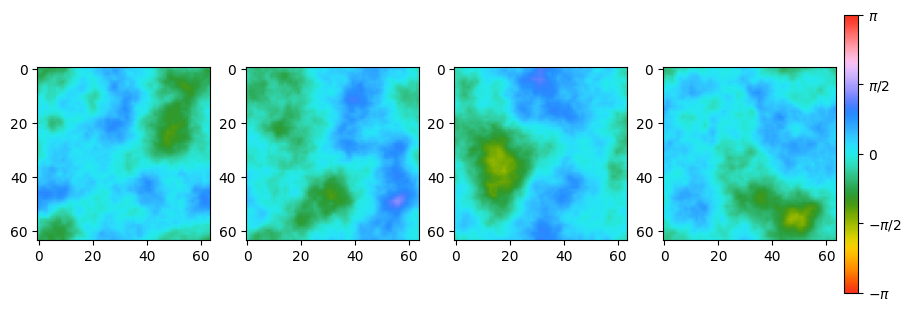

In [17]:
# Plot phase screens
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
fig = plt.figure(1, figsize=(9,3), constrained_layout=True)
axes=[]
images=[]
for j in range(numberOfPhaseScreens):
    ax = fig.add_subplot(1,numberOfPhaseScreens,j+1)
    im = ax.imshow(wrap_to_pi(abbs[j].scrn), cmap=pmap, vmin=-np.pi, vmax=np.pi)
    axes.append(ax)
    images.append(im)
cbar = fig.colorbar(im)
cbar.set_ticks(ticks)
cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])

In [ ]:
abbs[0].scrn

array([[-0.75651506, -0.71620004, -0.75526898, ..., -0.66284041,
        -0.7604683 , -0.80664829],
       [-0.68677528, -0.65270333, -0.79518603, ..., -0.7352533 ,
        -0.86825953, -0.87024387],
       [-0.75527022, -0.71856536, -0.79885031, ..., -0.74547514,
        -0.81692315, -0.81839868],
       ...,
       [-0.47952272, -0.66867296, -0.77275755, ..., -0.27727883,
        -0.28411084, -0.33758053],
       [-0.61249006, -0.74331993, -0.7704674 , ..., -0.41591051,
        -0.45686868, -0.50810264],
       [-0.70388054, -0.76317235, -0.75416259, ..., -0.56317462,
        -0.63593372, -0.69032784]], shape=(64, 64))

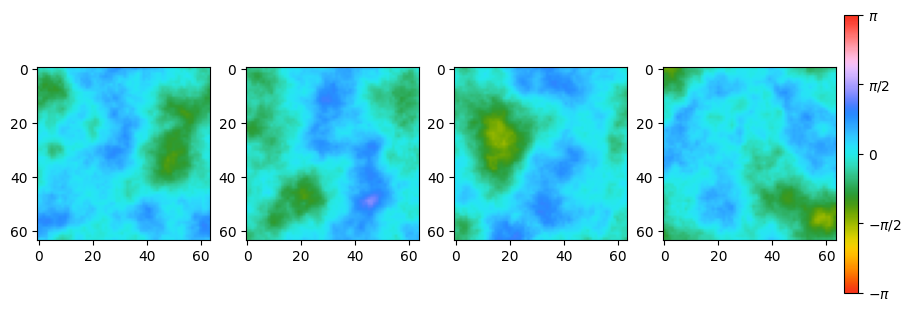

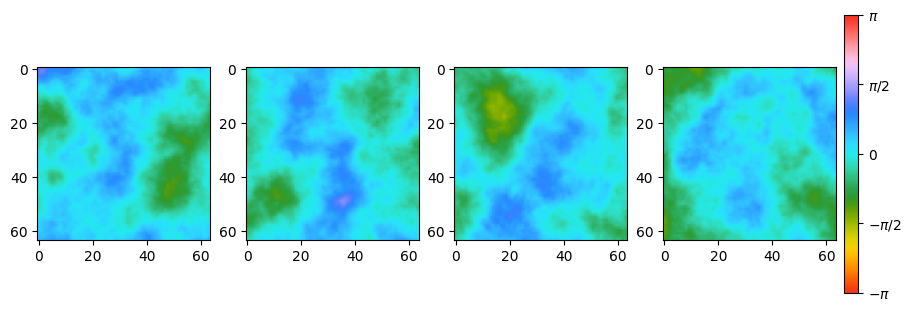

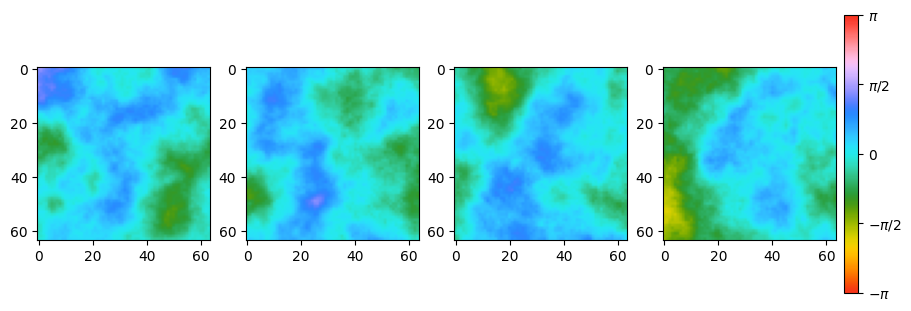

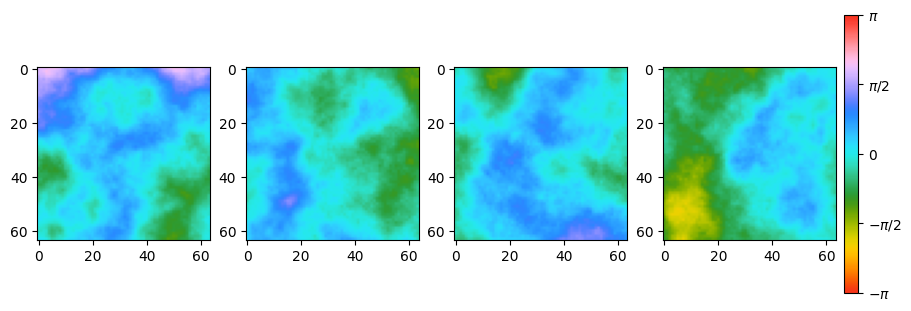

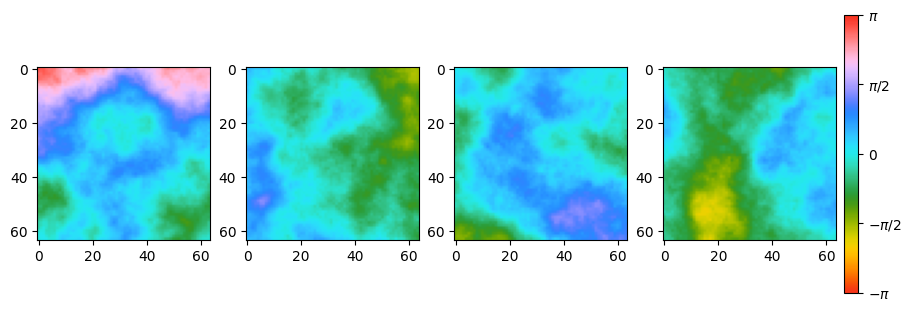

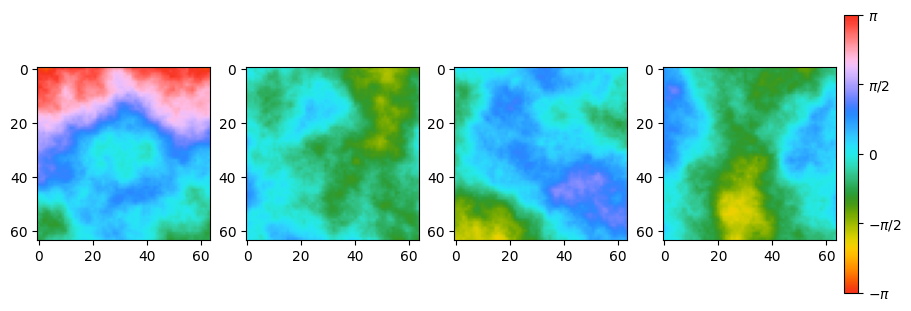

In [ ]:
errorBeams=[]
numberOfFluctuations = 5
shift = 10 # How many rows to add with every fluctuation
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]


abbs=[PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed+i) for i in range(numberOfPhaseScreens)]

for i in range(numberOfFluctuations+1):
    for j,screen in enumerate(abbs):
        extend_phase_screen(screen,direction=j,num_steps=shift)
    # Plot phase screens
    fig = plt.figure(i+1, figsize=(9,3), constrained_layout=True)
    axes=[]
    images=[]
    for j in range(numberOfPhaseScreens):
        ax = fig.add_subplot(1,numberOfPhaseScreens,j+1)
        im = ax.imshow(wrap_to_pi(abbs[j].scrn), cmap=pmap, vmin=-np.pi, vmax=np.pi)
        axes.append(ax)
        images.append(im)
    cbar = fig.colorbar(im)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
    # errorBeams.append(propChannel(OAM(F,w0,0),z,abbs_fluctuation))

In [ ]:
os.makedirs("images/gaussian_prop", exist_ok=True)

for i,Beam in enumerate(errorBeams):
    plot_beam(Beam, rows=1, aperature=size/3)
    plt.savefig(
        f"images/gaussian_prop/step_{i:04d}.png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0
    )
    #plt.show()
    plt.close()

# Calculate EigenModes

## Calculate eigenvalues and eigenvectors

In [ ]:
transferMatrix=endFields

transferMatrixT=endFields.T

transferMatrixH=endFields.T.conj()

transferMatrixHermitian=transferMatrixH@transferMatrix

eigVals,eigVecs=np.linalg.eig(transferMatrixT)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [ ]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

## Plot Eigenvalues

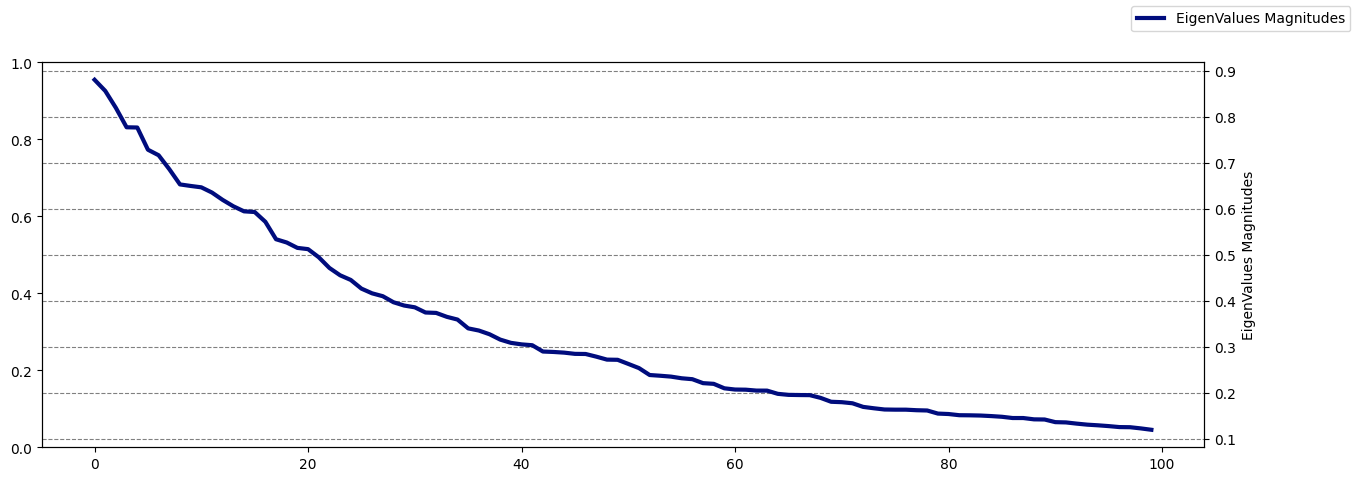

In [ ]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:100],eigMags[:100],label='EigenValues Magnitudes',color=customColoursBGY[0],linewidth=3)

fig.legend()
plt.show()

## Create Optical Modes

In [ ]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams=[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

eigenBeamPropagated=[propChannel(beam,z,abbs) for beam in progress(eigenBeams)]


100%|██████████| 100/100 [00:00<00:00, 323.77it/s]


### Normalize phase for plotting

In [ ]:
############################
####
####
#### Need to normalize the phase on the propagated eigenmode to be able 
####    to display them next to one another and have consistent phase profiles.
####
############################

In [ ]:
# Loop through eigenbeams and find position with max intensity and then find the phase there. Then find the difference in phase in the
# same position after propagating and subtract the entire array after propagating by this phase difference

for i, eigenBeam in enumerate(eigenBeams):
    intensity = Intensity(eigenBeam,1)
    max_pos = np.unravel_index(intensity.argmax(), intensity.shape)
    phase_diff = np.mod(Phase(eigenBeamPropagated[i]), 2*np.pi)[max_pos] - np.mod(Phase(eigenBeam), 2*np.pi)[max_pos]
    eigenBeamPropagated[i].field *= np.exp(1j * (-phase_diff)) # Subtract phase difference

## Plot Optical Modes

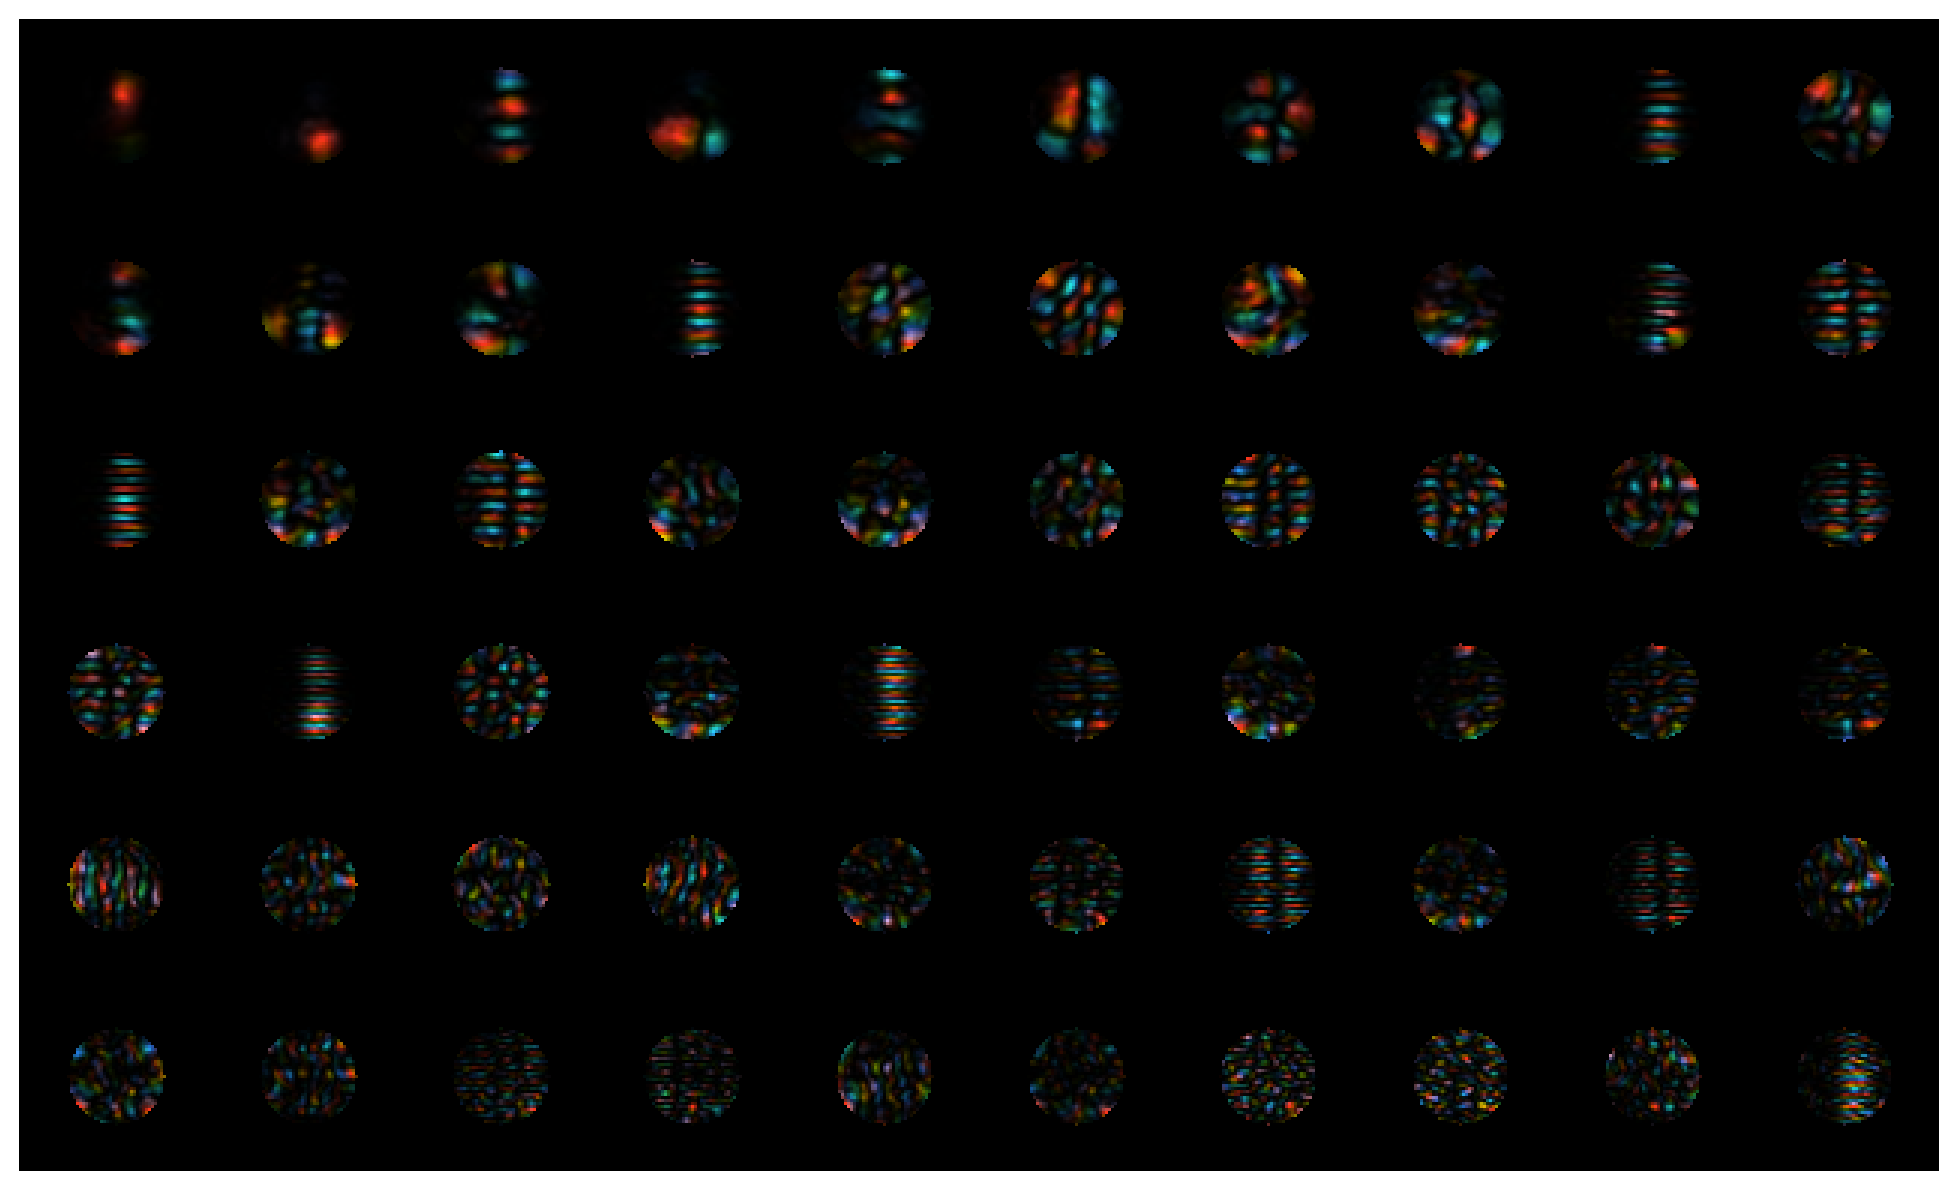

In [ ]:
plot=plot_beam(eigenBeams[:60],rows=6,dpi=N*3)
plt.show();plt.close()

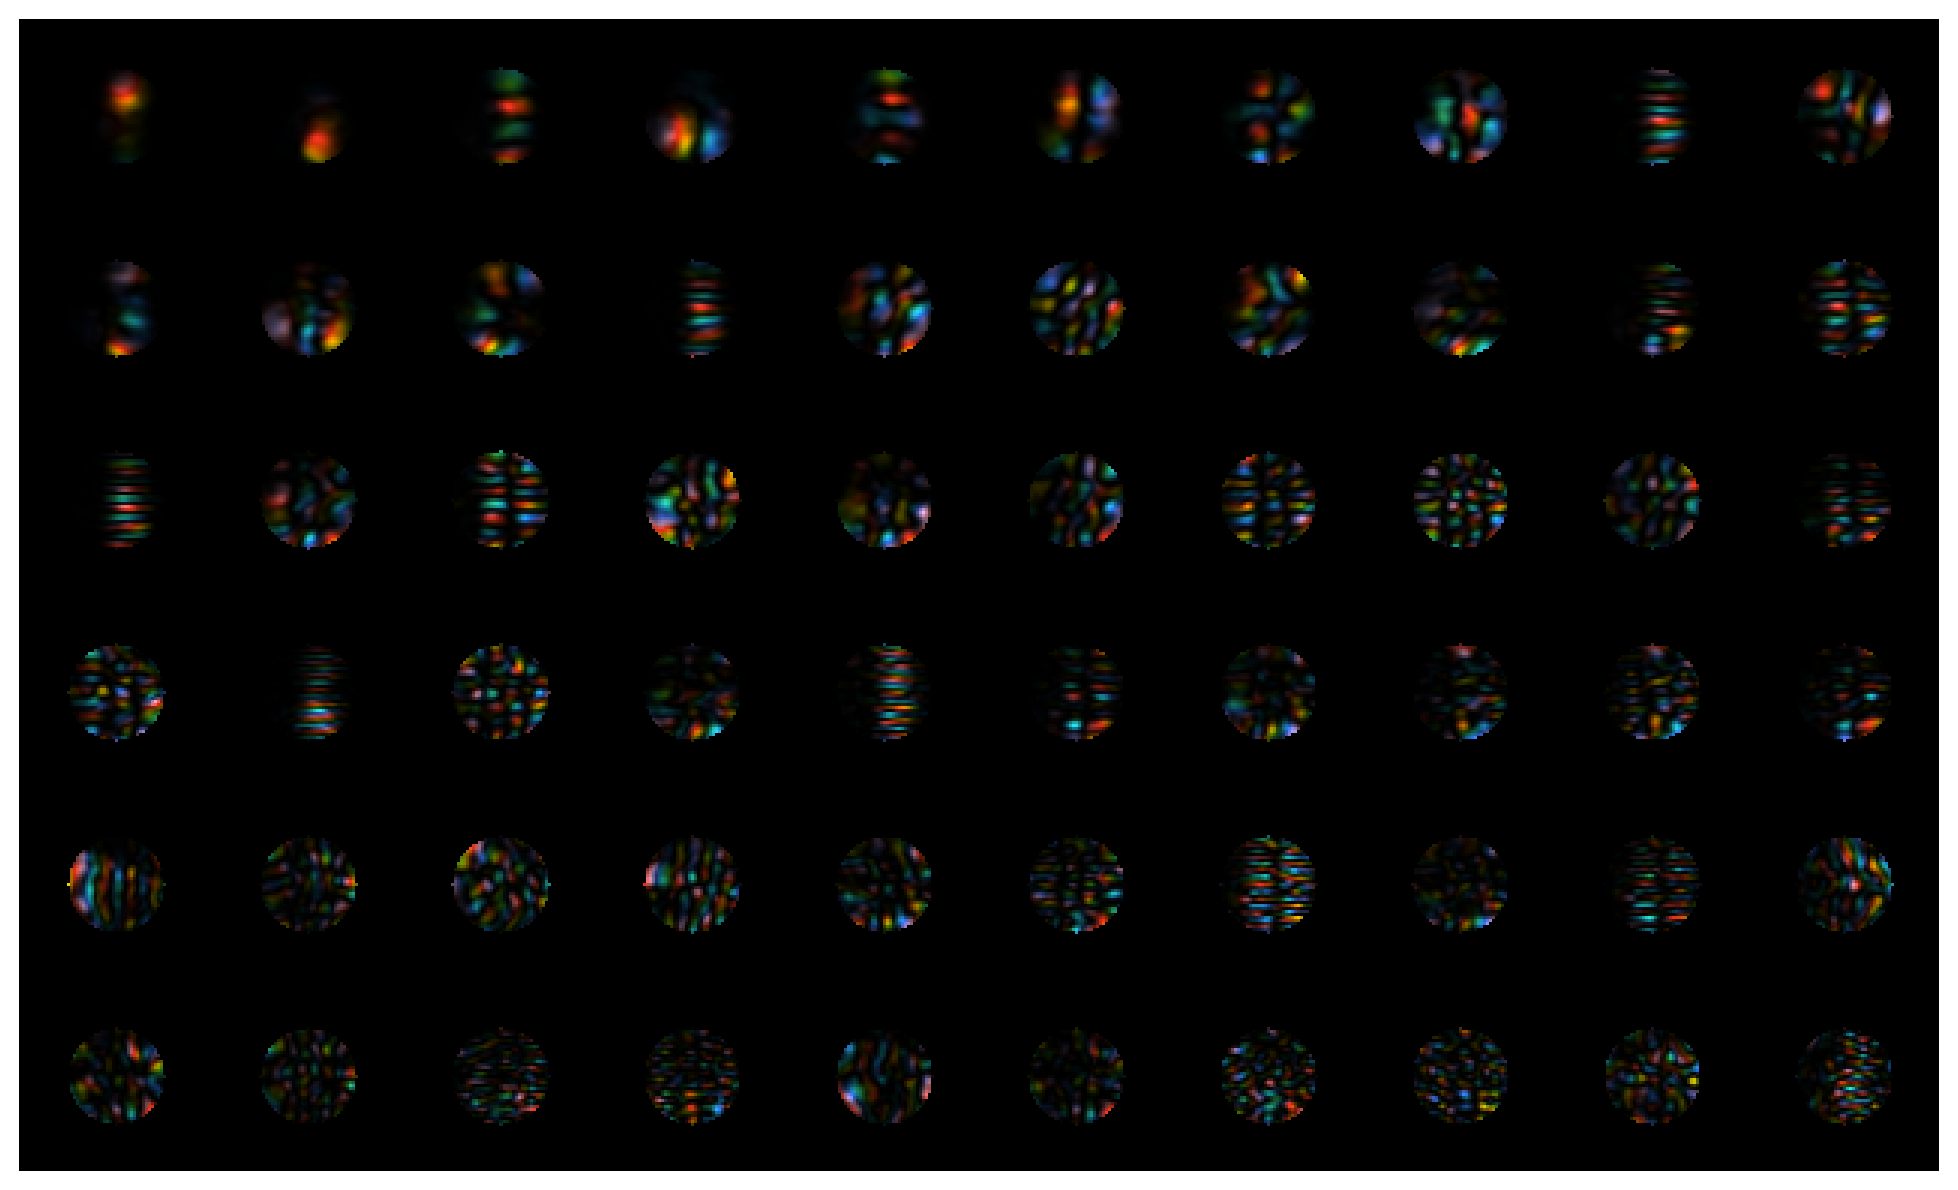

In [ ]:
plot=plot_beam([CircAperture(beam,R=lensSize) for beam in eigenBeamPropagated[:60]],rows=6,dpi=N*3)
plt.show();plt.close()

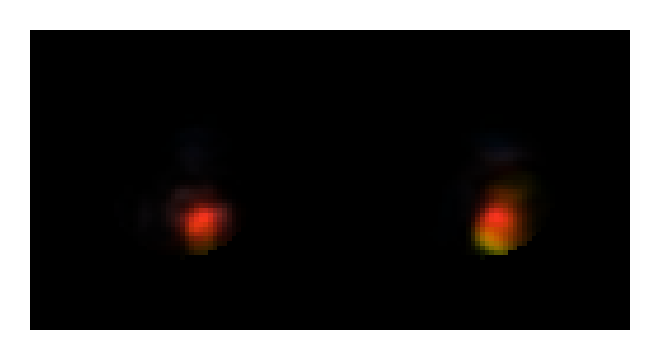

In [ ]:
plt.show(plot_beam([eigenBeams[1],CircAperture(eigenBeamPropagated[1],R=lensSize)]))

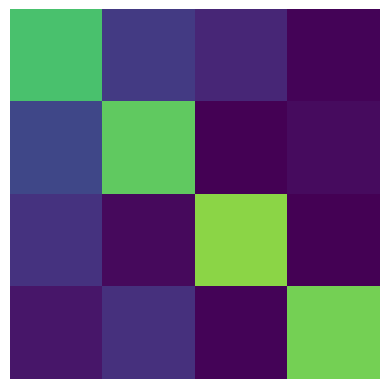

Error rate of 0.2286540138283495 when doing a measurement in the unpropagated Eigenmode basis


In [ ]:
modeNumber=4

bestEigenBeams=eigenBeams[:modeNumber]
bestEigenBeamsPropagated=eigenBeamPropagated[:modeNumber]


plt.show(plotCrosstalk(crosstalk(bestEigenBeams,bestEigenBeamsPropagated)))
print(f'Error rate of {beamsError(bestEigenBeams,bestEigenBeamsPropagated)} when doing a measurement in the unpropagated Eigenmode basis')